<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/03_data_science_modules/03_winter_temperature_enso.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook examines the relationship between winter minimum temperatures in southern central IN and El Nino.

**Goal:** examine the relationship between El Nino and minimum winter (Dec-Jan-Feb) temperatures in Bloomington, IN

**Method:**

 * obtain minimum temperature data from [NOAA NClimDiv](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00005), using the *NCEI Direct Download* method
 * read the dataset using `pandas`, filter out data for southern central Indiana
 * convert the data to timeseries format
 * obtain the [ENSO longitude index](https://cascade.lbl.gov/enso-longitude-index-eli/) Excel file and read with `pandas`; convert to timeseries format
 * make the ENSO and NClimDiv timeseries align (same start and end dates, same period - DJF, etc)
 * plot both timeseries
 * plot a scatter plot
 * do linear regression and correlation analyses

For this solution notebook, I will be using data directly from NOAA instead of downloading it, since `pandas` has the ability to open data from a URL.

# Part 1: Getting the NClimDiv data

**Important:** Download this notebook and place it in your course folder, running it in Visual Studio Code (not Google Colab).  You'll commit this to your git repository at the end.

In [1]:
""" Import libraries """
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

In [2]:
""" Read the tmin data file. """
# month and date in the url need to be updated over time
climdiv_url = "https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmindv-v1.0.0-20240506"

# set the header manually
header = ["code"]
header = header + list(range(1,13))

# read the data file from url
""" Correction: 
Better use 'sep' argument rather than 'delimiter'. 'sep' is more commonly used though they are the same in read_csv() 
'\s+' suggests one or more white space which is handy """
climdiv_df = pd.read_csv(climdiv_url, header=None, names=header, sep="\s+", na_values=-99.9)
climdiv_df

,code,1,2,3,4,5,6,7,8,9,10,11,12
0,101281895,27.5,21.8,37.4,47.8,54.7,63.5,66.5,65.9,63.1,37.9,37.4,30.6
1,101281896,30.3,32.6,36.6,52.2,61.1,63.6,68.7,67.1,57.2,44.8,40.1,31.2
2,101281897,26.8,37.4,45.1,47.0,52.4,64.7,68.0,65.2,59.0,48.8,36.5,32.9
3,101281898,34.7,31.0,45.1,42.7,57.4,66.0,68.5,67.1,63.0,47.0,34.5,28.0
4,101281899,28.8,22.2,38.8,47.8,61.2,65.1,66.9,68.3,56.8,50.7,40.3,28.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46015,5013282020,18.5,26.0,27.3,33.0,36.9,42.7,47.5,47.3,42.3,37.5,31.6,25.1
46016,5013282021,24.3,30.1,26.8,31.6,36.5,42.2,46.3,47.6,43.3,36.0,25.3,31.1
46017,5013282022,24.2,28.6,26.2,30.4,34.3,42.1,45.3,47.0,44.2,37.3,33.3,29.4
46018,5013282023,23.7,26.3,29.1,29.5,34.5,41.8,47.1,48.1,43.9,38.9,32.8,23.6


In [3]:
""" Filter out other regions but south central Indiana. """
""" Correction: Unify the variable naming strategy """
# set the state and division code
state_code = "12" # Indiana
div_num = "08" # South Central division
state_div = state_code + div_num

# get the rows that are in the requested climate division
code_str = climdiv_df['code'].astype(str).str # convert the code column to a string
""" Note: .str allows the access to string methods which are not directly available in dataframe type """
div_idx = code_str.startswith(state_div) # search the code column for entries starting with 1208

# select only those rows using boolean indexing
SCIN_df = climdiv_df[div_idx]

SCIN_df



,code,1,2,3,4,5,6,7,8,9,10,11,12
10790,1208281895,14.5,11.1,28.5,42.8,50.1,61.6,61.8,62.1,56.9,33.6,31.6,25.8
10791,1208281896,22.8,23.5,26.5,47.8,56.6,59.7,64.9,62.1,52.8,37.7,34.4,27.0
10792,1208281897,17.8,25.4,33.3,40.8,45.1,58.4,65.6,60.3,53.6,45.3,32.6,25.8
10793,1208281898,26.0,23.8,36.2,38.8,53.1,61.5,64.9,63.9,58.8,45.0,28.8,20.6
10794,1208281899,20.7,12.7,29.4,43.9,55.1,62.8,63.0,64.4,53.1,46.5,36.1,21.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915,1208282020,29.3,27.6,38.2,39.1,50.2,60.3,66.3,62.1,54.3,43.4,36.4,26.4
10916,1208282021,25.4,19.6,35.6,41.0,49.0,62.2,64.7,65.0,57.2,51.3,29.4,33.3
10917,1208282022,17.6,23.1,34.2,40.6,54.9,60.0,66.4,63.5,55.7,39.5,33.1,25.9
10918,1208282023,31.3,30.1,33.1,41.4,51.4,57.3,65.4,62.4,55.6,46.4,33.2,32.5


In [4]:
""" Convert the dataset to a timeseries. """
# convert the dataframe to numpy array
""" Correction:
DataFrame.to_numpy() is recommended instead of df.values which is deprecated now """
SCIN_np = SCIN_df.to_numpy()

# pull out only the temperature data
""" Correction: no need to specify the ending index if it is the very end """
tmin_np = SCIN_np[:,1:]
# check the data by printing out shape
print(tmin_np.shape)

# convert the matrix to a vector
tmin_data = tmin_np.ravel()

# create the time/dates axis
tmin_dates = pd.date_range(start = '1895-01-1', end = '2025-01-01', freq = '1M')
print(tmin_dates.shape)

(130, 12)
(1560,)


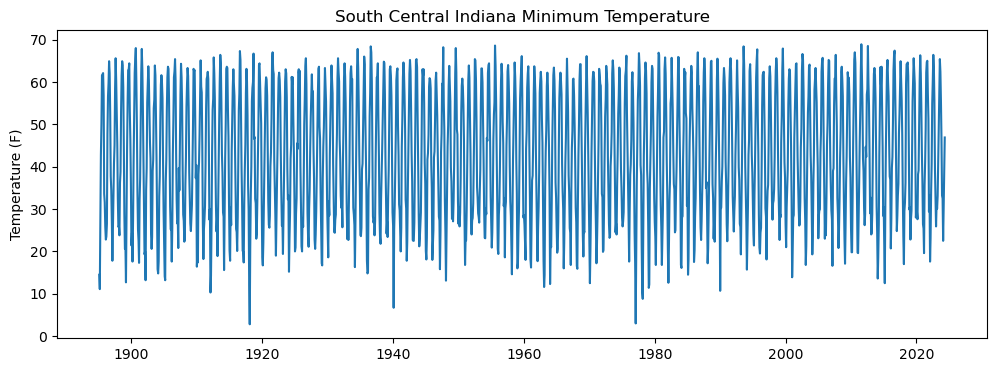

In [5]:
""" Plot the time series of temperature"""
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(tmin_dates, tmin_data)
ax.set_title("South Central Indiana Minimum Temperature")
ax.set_ylabel("Temperature (F)")
plt.show()

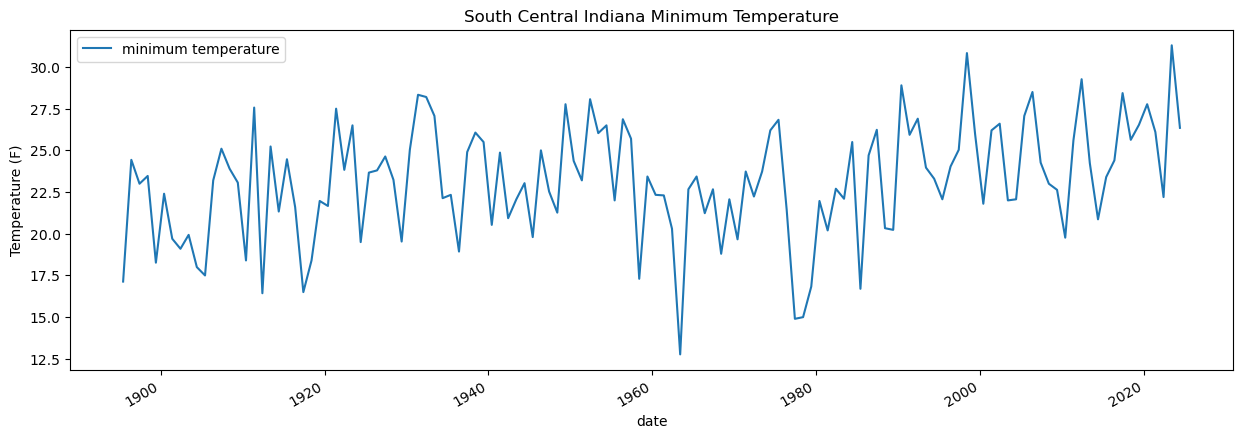

In [6]:
""" calculate average over winter months (DJF) """

# create a new dataframe for the timeseries
tmin_df = pd.DataFrame({'date' : tmin_dates, 'minimum temperature' : tmin_data})

# select only the winter months
months = tmin_df['date'].dt.month # get the month values for each date
""" Note: .dt is the attribute of Pandas Series only, not DataFrame """
winter_idx = months.isin([12, 1, 2])
# use boolean indexing to select only the winter months
tmin_winter_df = tmin_df[winter_idx]

# group by year and average over the winter months
years = tmin_winter_df['date'].dt.year # pull out the year for each date
tmin_winter_avg = tmin_winter_df.groupby(years).mean()

# plot the timeseries of mean minimum temperature in winter using pandas built-in plot
fig, ax = plt.subplots(figsize=(15,5))
tmin_winter_avg.plot(x='date', y='minimum temperature', ax=ax)
ax.set_ylabel("Temperature (F)")
ax.set_title("South Central Indiana Minimum Temperature")
plt.show()

# Part 2: Reading and opening El Nino data

In [7]:
# set the URL to the ELI file
eli_url = "https://portal.nersc.gov/archive/home/projects/cascade/www/ELI/ELI_ERSSTv5_1854.01-2020.05.xlsx"

# read the ELI data
""" Correction: add index_col in arguments """
eli_df = pd.read_excel(eli_url, sheet_name="ELI_ERSSTv5_1854.01-2020.02", header=0, index_col=0)
eli_df

,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Jan,158.62,156.95,163.24,151.52,164.42,158.76,156.20,159.05,155.27,158.75,...,150.93,152.95,155.70,157.64,160.75,175.10,155.08,154.20,160.23,158.67
Feb,159.30,159.96,158.84,154.36,167.38,154.50,153.08,178.75,156.26,178.35,...,150.42,153.97,154.62,157.65,160.22,172.86,156.50,154.15,163.96,158.26
Mar,154.63,155.97,158.07,150.68,154.81,157.37,161.36,172.58,159.08,166.54,...,146.19,153.88,147.89,158.11,161.58,164.78,158.90,151.16,161.35,155.82
Apr,154.60,154.78,150.77,147.31,162.29,154.51,152.08,151.74,151.58,154.86,...,146.99,158.13,148.63,154.01,164.81,155.91,156.11,152.29,157.37,152.13
May,160.56,159.68,157.31,157.18,163.30,155.67,155.39,153.93,154.05,153.56,...,148.74,151.82,157.76,157.77,167.87,160.95,157.20,157.35,161.7,154.51
Jun,167.42,164.79,160.78,175.59,166.08,159.56,168.50,158.09,161.82,158.75,...,160.46,163.68,163.07,168.99,179.12,162.99,166.31,163.56,169.81,NaN
Jul,171.27,169.29,164.36,170.79,168.07,172.13,174.46,162.12,163.93,175.96,...,165.15,171.93,165.38,172.30,182.31,162.86,167.77,167.36,170.99,NaN
Aug,170.06,164.72,162.23,168.05,165.31,171.72,168.99,168.20,167.53,169.20,...,163.99,170.16,165.98,170.86,182.46,160.89,165.69,167.66,169.55,NaN
Sep,167.25,170.77,157.28,171.20,163.19,166.94,160.77,167.22,172.79,165.32,...,162.47,167.07,164.86,168.46,181.57,159.52,165.12,165.77,167.04,NaN
Oct,162.51,171.23,163.08,167.59,163.84,165.18,157.49,158.13,169.94,160.51,...,158.79,164.63,161.79,164.21,179.94,156.15,161.67,165.35,164.16,NaN


hint: use the `merge()` method in pandas to get the ELI and NOAA data to align.

In [8]:
""" Extract the ELI data in winter months (DJF) and calculate average
Alternative preprocessing way in addition to converting DataFrame to numpy array """

# remove rows in other months (return a copy if inplace=False)
eli_winter_df = eli_df.drop(index=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])

# transpose the axes
eli_winter_df = eli_winter_df.transpose()

# calculate the mean over the columns direction (months)
eli_winter_df['eli'] = eli_winter_df.mean(axis=1)

# add a 'year' column while reset the row index to default
eli_winter_df = eli_winter_df.rename_axis('year').reset_index()
eli_winter_df

,year,Jan,Feb,Dec,eli
0,1854,158.62,159.3,155.39,157.77
1,1855,156.95,159.96,170.07,162.326667
2,1856,163.24,158.84,158.21,160.096667
3,1857,151.52,154.36,163.04,156.306667
4,1858,164.42,167.38,158.08,163.293333
...,...,...,...,...,...
162,2016,175.1,172.86,155.6,167.853333
163,2017,155.08,156.5,155.97,155.85
164,2018,154.2,154.15,161.52,156.623333
165,2019,160.23,163.96,160.333,161.507667


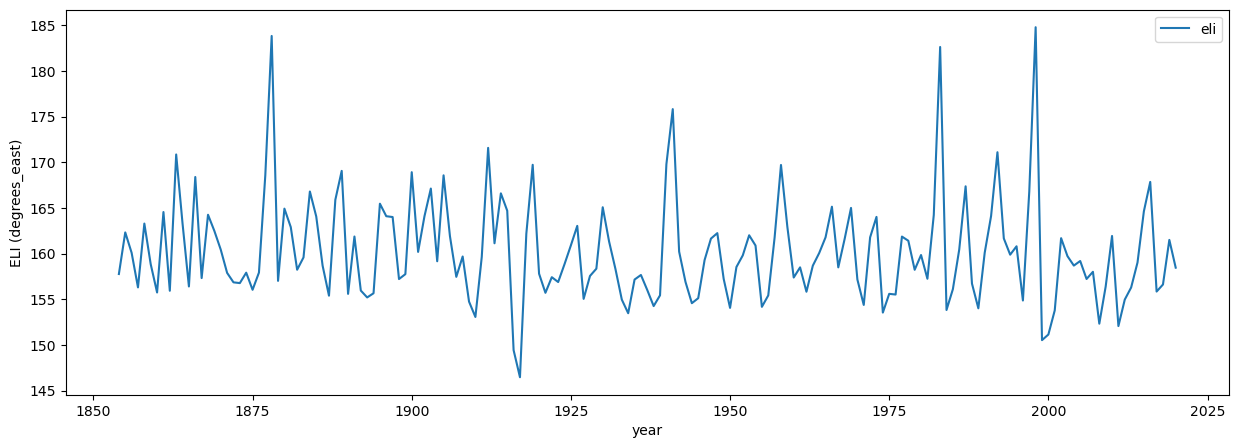

In [9]:
""" Plot the ELI time series"""
fig, ax = plt.subplots(figsize=(15,5))
eli_winter_df.plot(x='year', y='eli', ax=ax)
ax.set_ylabel("ELI (degrees_east)")

plt.show()

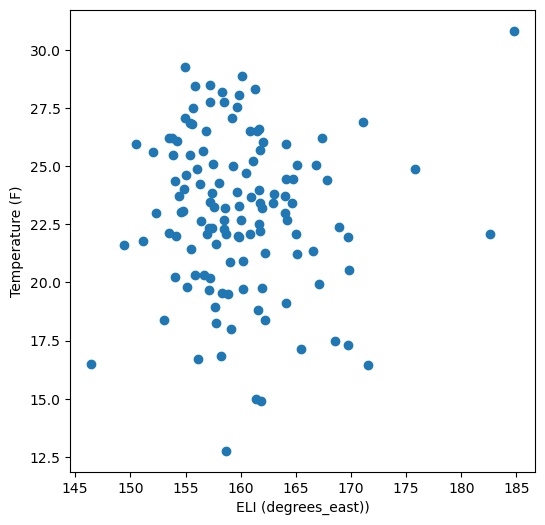

In [10]:
""" Combine the two dataframes """
# inner join on column 'year'
tmin_winter_avg['year'] = tmin_winter_avg['date'].dt.year
tmin_eli_df = pd.merge(tmin_winter_avg, eli_winter_df, on='year')

# remove unnecessary columns
tmin_eli_df.drop(columns=['Jan', 'Feb', 'Dec', 'date'], inplace=True)
tmin_eli_df

# make a scatter plot to reveal relationship
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(tmin_eli_df['eli'], tmin_eli_df['minimum temperature'])
ax.set_xlabel("ELI (degrees_east))")
ax.set_ylabel("Temperature (F)")
plt.show()

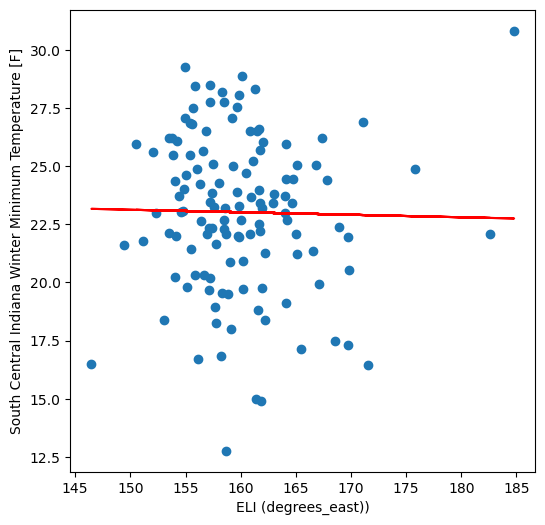

In [11]:
""" Calculate the correlation coefficient and draw regression line. 
Credit: 03_winter_temperature_enso_SOLUTION.ipynb """

# calculate the correlation coefficient
corr_matrix = tmin_eli_df[['eli', 'minimum temperature']].corr()
corr = corr_matrix.iloc[0,1]

# calculate the regression line using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tmin_eli_df['eli'].astype(float), tmin_eli_df['minimum temperature'].astype(float))
m = slope
b = intercept

# plot the data with the regression line
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(tmin_eli_df['eli'], tmin_eli_df['minimum temperature'])
ax.plot(tmin_eli_df['eli'], m * tmin_eli_df['eli'] + b, color='red')
ax.set_xlabel("ELI (degrees_east))")
ax.set_ylabel("South Central Indiana Winter Minimum Temperature [F]")
plt.show()

In [12]:
type(tmin_eli_df['minimum temperature'][0])

numpy.float64